# Leaky integrate-and-fire モデル
## LIFモデルの定義
生理学的なイオンチャネルの挙動は考慮せず, 入力電流を膜電位が閾値に達するまで時間的に積分するというモデルを**Integrate-and-fire (IF, 積分発火)モデル** という．さらに, IFモデルにおいて膜電位の漏れ(leak)[^leak]も考慮したモデルを **Leaky integrate-and-fire (LIF, 漏れ積分発火) モデル** と呼ぶ．ここではLIFモデルのみを取り扱う．

ニューロンの膜電位を$V_m(t)$, 静止膜電位を$V_\text{rest}$, 入力電流[^isyn]を$I(t)$, 膜抵抗を$R_m$, 膜電位の時定数を$\tau_m\ (=R_m \cdot C_m)$とすると, 式は次のようになる[^vrest]．

$$
\begin{equation}
\tau_m \frac{dV_{m}(t)}{dt}=-(V_{m}(t)-V_\text{rest})+R_mI(t)
\end{equation}
$$

ここで, $V_m$が閾値(threshold)[^theta]$V_{\text{th}}$を超えると, 脱分極が起こり, 膜電位はピーク電位 $V_{\text{peak}}$まで上昇する．発火後は再分極が起こり, 膜電位はリセット電位 $V_{\text{reset}}$まで低下すると仮定する[^reset]．発火後, 一定の期間$\tau_{\text{ref}}$ の間は膜電位が変化しない[^ref], とする．これを **不応期(refractory time period)** と呼ぶ．

以上を踏まえてLIFモデルを実装してみよう．まず必要なパッケージを読み込む．

[^leak]: この漏れはイオンの拡散などによるもの． 
[^isyn]: シナプス入力による電流がどうなるかは，第三章「シナプス伝達のモデル」で扱う．
[^vrest]: $(V_{m}(t)-V_\text{rest})$の部分は膜電位の基準を静止膜電位としたことにして, 単に$V_m(t)$だけの場合もある． また, 右辺の$RI(t)$の部分は単に$I(t)$とされることもある． 同じ表記だが, この場合の$I(t)$はシナプス電流に比例する量, となっている(単位はmV)． 
[^theta]: thから始まるので文字$\theta$が使われることもある．
[^reset]: リセット電位は静止膜電位と同じ場合もあれば, 過分極を考慮して静止膜電位より低めに設定することもある．
[^ref]: 実装によっては不応期の間は膜電位の変化は許容するが発火は生じないようにすることもある．

In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using PyPlot
rc("axes.spines", top=false, right=false)

HHモデルと同様に変更しない定数を保持する `struct` の `LIFParameter` と, 変数を保持する `mutable struct` の `LIF` を作成する．

In [2]:
@kwdef struct LIFParameter{FT}
    tref::FT = 2; tc_m::FT = 10 # 不応期, 膜時定数 (ms)
    vrest::FT = -60; vreset::FT = -65; vthr::FT = -40; vpeak::FT = 30 #　静止膜電位, リセット電位, 閾値電位, ピーク電位 (mV)
end

@kwdef mutable struct LIF{FT}
    param::LIFParameter = LIFParameter{FT}()
    N::UInt32 #ニューロンの数
    v::Vector{FT} = fill(-65.0, N); v_::Vector{FT} = fill(-65.0, N) # 膜電位, 発火電位も記録する膜電位 (mV)
    fire::Vector{Bool} = zeros(Bool, N) # 発火
    tlast::Vector{FT} = zeros(N) # 最後の発火時刻 (ms)
    tcount::FT = 0 # 時間カウント
end

次に変数を更新する関数`update!`を書く．

In [3]:
function update!(variable::LIF, param::LIFParameter, Ie::Vector, dt)
    @unpack N, v, v_, fire, tlast, tcount = variable
    @unpack tref, tc_m, vrest, vreset, vthr, vpeak = param
    
    @inbounds for i = 1:N
        #v[i] += dt * ((vrest - v[i] + Ie[i]) / tc_m) # 不応期を考慮しない場合の更新式
        v[i] += dt * ((dt*tcount) > (tlast[i] + tref))*((vrest - v[i] + Ie[i]) / tc_m)
        #v[i] += dt * ifelse(dt*tcount[1] > tlast[i] + tref, (vrest - v[i] + Ie[i]) / tc_m, 0)
    end
    @inbounds for i = 1:N
        fire[i] = v[i] >= vthr
        v_[i] = ifelse(fire[i], vpeak, v[i]) #発火時の電位も含めて記録するための変数 (除いてもよい)
        v[i] = ifelse(fire[i], vreset, v[i])        
        tlast[i] = ifelse(fire[i], dt*tcount, tlast[i]) # 発火時刻の更新
    end
end

update! (generic function with 1 method)

いくつかの処理について解説しておく．まず，一番目のforループ内の`v[i]`の`((dt*tcount) > (tlast[i] + tref))`は最後にニューロンが発火した時刻`tlast[i]`に不応期`tref`を足した時刻よりも現在の時刻`dt*tcount[1]`が大きければ膜電位の更新を許可し，小さければ更新しない．二番目のforループにおける`fire[i]`はニューロンの膜電位が閾値電位`vthr`を超えたら`True`となる．`v[i]`などの更新式にある`ifelse(a, b, c)`はaが`True`の時はbを返し，`False`の時はcを返す関数であり，`v[i] = ifelse(fire[i], vreset, v[i])`は`fire[i]`が`True`なら`v[i]`をリセット電位`vreset`とし，そうでなければそのままの値を返すという処理である．同様にして`tlast[i]`は発火したときにその時刻を記録する変数となっている．なお，`v_[i] = ifelse(fire[i], vpeak, v[i])`は実際のシミュレーションにおいて意味をなさない．単に発火時の電位`vpeak`を含めて記録すると描画時の見栄えが良いというだけである．

これらの`struct`と関数を用いてシミュレーションを実行する．`I` はHHモデルのときと同じように矩形波を入力する．実は`I`は入力電流ではなく入力電流に比例する量となっているが，これは膜抵抗を乗じた後の値であると考えるとよい．

## LIFモデルのシミュレーションの実行
いくつかの定数を設定してシミュレーションを実行する．

In [4]:
T = 450 # ms
dt = 0.01f0 # ms
nt = UInt32(T/dt) # number of timesteps
N = 1 # ニューロンの数

# 入力刺激
t = Array{Float32}(1:nt)*dt
Ie = repeat(25f0 * ((t .> 50) - (t .> 200)) + 50f0 * ((t .> 250) - (t .> 400)), 1, N)  # injection current

# 記録用
varr = zeros(Float32, nt, N)

# modelの定義
neurons = LIF{Float32}(N=N)

# simulation
@time for i = 1:nt
    update!(neurons, neurons.param, Ie[i, :], dt)
    neurons.tcount += 1
    varr[i, :] = neurons.v_
end

  0.154446 seconds (751.90 k allocations: 20.630 MiB, 6.57% gc time, 65.97% compilation time)


発火時電位を含む膜電位`v_`と入力電流`I`を描画する．

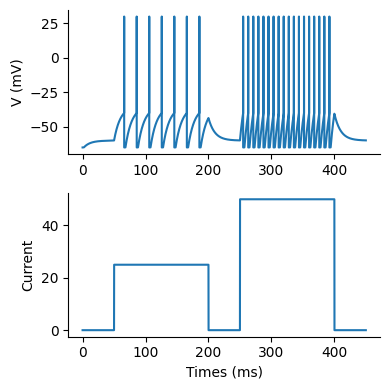

In [5]:
figure(figsize=(4, 4))
subplot(2,1,1); plot(t, varr[:, 1]); ylabel("V (mV)")
subplot(2,1,2); plot(t, Ie[:, 1]); ylabel("Current");  xlabel("Times (ms)")
tight_layout()

## LIFモデルのF-I curve
### 数値的計算によるF-I curveの描画
この項目ではLIFモデルにおける入力電流に対する発火率の変化 (F-I curve)を描画する．方法はHHモデルの場合と同様だが，今回は発火したかどうかがモデル内の変数として明示的に記録されているので処理が少ない．

In [6]:
T = 1000 # ms
dt = 0.01f0 # ms
nt = UInt32(T/dt) # number of timesteps
N = 100 # ニューロンの数

# 入力刺激
mincurrent, maxcurrent = 15, 40
t = Array{Float32}(1:nt)*dt
Ie = Array{Float32}(range(mincurrent,maxcurrent,length=N)) # injection current

# modelの定義
neurons = LIF{Float32}(N=N)

# 記録用
firearr = zeros(Bool, nt, N)

# simulation
@time for i = 1:nt
    update!(neurons, neurons.param, Ie, dt)
    neurons.tcount += 1
    firearr[i, :] = neurons.fire
end

  0.129403 seconds (959.42 k allocations: 18.443 MiB, 6.69% gc time, 24.43% compilation time)


発火率を計算し，描画する．

In [7]:
num_spikes = sum(firearr, dims=1)
rate_numeric = num_spikes/T*1e3; 

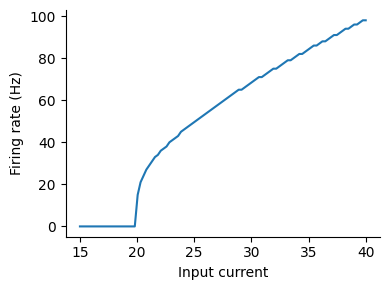

In [8]:
figure(figsize=(4, 3))
plot(Ie, rate_numeric[1, :]); xlabel("Input current"); ylabel("Firing rate (Hz)")
tight_layout()

さらに電流を強めると発火率は飽和(saturation)する．なお，不応期がない，すなわち0の場合は閾値付近以外はReLU関数のような挙動をする．

### 解析的計算によるF-I curveの描画
ここまでは数値的なシミュレーションによりF-I curveを求めた．以下では解析的にF-I curveの式を求めよう．具体的には，一定かつ持続的な入力電流を$I$としたときのLIFニューロンの発火率(firing rate)が

$$
\begin{equation}
\text{rate}\approx \left(\tau_m \ln \frac{R_mI}{R_mI＋V_\text{rest}-V_{\text{th}}}\right)^{-1}
\end{equation}
$$

と近似できることを示す．まず，$t=t_1$にスパイクが生じたとする．このとき, 膜電位はリセットされるので$V_m(t_1)=V_\text{rest}$である(リセット電位と静止膜電位が同じと仮定する)．$[t_1, t]$における膜電位はLIFの式を積分することで得られる．

$$
\begin{equation}
\tau_m \frac{dV_{m}(t)}{dt}=-(V_{m}(t)-V_\text{rest})+R_m I
\end{equation}
$$

の式を積分すると, 

$$
\begin{aligned}
\int_{t_1}^{t} \frac{\tau_m dV_m}{R_mI＋V_\text{rest}-V_m}&=\int_{t_1}^{t} dt\\
\ln \left(1-\frac{V_m(t)-V_\text{rest}}{R_mI}\right)&=-\frac{t-t_1}{\tau_m} \quad (\because V_m(t_1)=V_\text{rest})\\
\therefore\ \ V_m(t) &=V_\text{rest} + R_mI\left[1-\exp\left(-\frac{t-t_1}{\tau_m}\right)\right] 
\end{aligned}
$$

となる．$t>t_1$における初めのスパイクが$t=t_2$に生じたとすると, そのときの膜電位は$V_m(t_2)=V_{\text{th}}$である (実際には閾値以上となっている場合もあるますが近似する)．$t=t_2$を上の式に代入して

$$
\begin{align}
V_{\text{th}}&=V_\text{rest} + R_mI\left[1-\exp\left(-\frac{t_2-t_1}{\tau}\right)\right] \\
\therefore\ \ T&= t_2-t_1 = \tau_m \ln \frac{R_mI}{R_mI＋V_\text{rest}-V_{\text{th}}}
\end{align}
$$

となる．ここで$T$は2つのスパイクの時間間隔 (spike interval)である．$t_1\leq t<t_2$におけるスパイクは$t=t_1$時の1つなので, 発火率は$1/T$となる．よって

$$
\text{rate}\approx \frac{1}{T}=\left(\tau_m \ln \frac{R_mI}{R_mI＋V_\text{rest}-V_{\text{th}}}\right)^{-1}
$$

となる．不応期$\tau_{\text{ref}}$を考慮すると, 持続的に入力がある場合は単純に$\tau_{\text{ref}}$だけ発火が遅れるので発火率は$1/(\tau_{\text{ref}}+T)$となる．

それではこの式に基づいてF-I curveを描画してみよう．

In [9]:
R = 1.0 #膜抵抗 
tc_m, tref = 10, 2# 膜時定数, 不応期 (ms)
vrest, vthr = -60.0, -40.0 # 静止膜電位, 閾値電位 (mV)
rate_exact = zeros(N)

for i = 1:N
    z = R*Ie[i] / (R*Ie[i] + vrest - vthr)
    rate_exact[i] = (z > 0) ? 1 / (tref + tc_m * log(z)) * 1e3 : 0
end 

`log`の中身が0になるとErrorが生じるので3項演算子で場合分けをしている．なお，`1e3`を乗じているのは1/msからHzに変換するためである．結果は次のようになる．数値的な計算結果とほぼ一致していることがわかる．

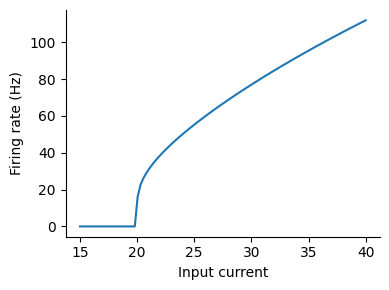

In [10]:
figure(figsize=(4, 3))
plot(Ie, rate_exact); xlabel("Input current"); ylabel("Firing rate (Hz)")
tight_layout()